In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
# from tcn import TemporalConvNet

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [48]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters ///////////////////////////////////////////////////////////////////////////////////////////
random_seed = 569
learning_rate = 1e-2
num_epochs = 1000
batch_size = 32
#///////////////////////////////////////////////////////////////////////////////////////////

# Architecture
input_size = 784
num_classes = 2
#num_features = 784
hidden_size = 500 #500
num_latent = 20
num_layers = 2

Device: cuda:0


In [65]:
# load dataset and cut it into train val part and shuffle them
data = np.loadtxt('sync_detection_data.txt')
label = np.loadtxt('sync_detection_label.txt')
N, D = np.shape(data)
label_int = np.zeros((N),dtype=int)
for k in range(N):
    label_int[k] = int(label[k])

ratio_train = 0.5
ind_cut = int(ratio_train * N)
ind = np.random.permutation(N)
train_data = data[ind[:ind_cut]]
train_datas = train_data[:256*40]
val_data = data[ind[ind_cut:]]

train_label = label[ind[:ind_cut]]
train_labels = train_label[:256*40]
val_label = label[ind[ind_cut:]]
print('dataset cutting success!--------------------')
print(np.shape(train_datas))

#mean = np.mean(train_datas)
#var = np.var(train_datas)
#print('preprocess----------------------------------')
#print('mean:')
#print(mean)
#print('sigma:')
#sigma = np.sqrt(var)
#print(sigma)
print('preprocess---------------------------------------------')
# preprocessing is so important
def data_in_one(inputdata):
    inputdata = (inputdata-inputdata.min())/(inputdata.max()-inputdata.min())
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

train_datas_process = data_in_one(train_data)
mean = np.mean(train_datas_process)
var = np.var(train_datas_process)
print('mean:')
print(mean)
print('sigma:')
sigma = np.sqrt(var)
print(sigma)

dataset cutting success!--------------------
(8584, 784)
preprocess---------------------------------------------
mean:
0.47023381276177695
sigma:
0.08384629220415142


In [66]:
np.shape(val_data)

(8584, 784)

In [49]:
##########################
### MODEL
##########################
print('model----------------------------------------------------------------------------------')

class VariationalAutoencoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_latent):
        super(VariationalAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder_lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#        self.fc = nn.Linear(hidden_size, num_classes)        
        ### ENCODER
#        self.hidden_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.z_mean = torch.nn.Linear(hidden_size, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(hidden_size, num_latent)
        
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent, hidden_size)
        self.decoder_lstm = torch.nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

#        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        x,_ = self.encoder_lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = x.view(-1,self.hidden_size)
#        x = self.hidden_1(x)
#        x = F.leaky_relu(x, negative_slope=0.0001)
        z_mean = self.z_mean(x)
#        z_mean = F.leaky_relu(z_mean, negative_slope=0.0001)
        z_log_var = self.z_log_var(x)
#        z_log_var = F.leaky_relu(z_log_var, negative_slope=0.0001)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded):
        x = self.linear_3(encoded)
#        x = F.leaky_relu(x, negative_slope=0.0001)
        x = x.view(-1,1,self.hidden_size)
        h1 = torch.zeros(self.num_layers, x.size(0), self.input_size).to(device) 
        c1 = torch.zeros(self.num_layers, x.size(0), self.input_size).to(device)
        x,_ = self.decoder_lstm(x,(h1,c1))
        x = torch.sigmoid(x) #0~1
        decoded = x.view(-1,1,self.input_size)
        return decoded

    def forward(self, x):
        
        z_mean, z_log_var, encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = VariationalAutoencoder(input_size,
                               hidden_size,
                               num_latent)
model = model.to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print('training ----------------------------------------------------------')

model----------------------------------------------------------------------------------
training ----------------------------------------------------------


In [50]:
# dir_name = 'model_43.pth'
resume_flag = True
if (resume_flag==True):
    checkpoint = torch.load(dir_name)
    model.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
else:    
    start_epoch = 0

In [51]:
start_time = time.time()
iters = int(256*40/batch_size)
for epoch in range(start_epoch,num_epochs):
    for batch_idx in range(iters):
        features = train_datas_process[batch_idx*batch_size:(batch_idx+1)*batch_size]
#        targets = train_labels[batch_idx*batch_size:(batch_idx+1)*batch_size]
#        targets = np.transpose(targets)
        features = torch.from_numpy(features)
#        targets = torch.from_numpy(targets)
        features = features.to(device,torch.float32)
        features = features.view(-1, 1, 28*28)
#        targets = targets.to(device,dtype=torch.int64)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        # add condition
#        x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)
        
        pixelwise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
#        pixelwise_bce = 0.0
        cost = kl_divergence + pixelwise_bce
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 40:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | kl_divergence: %.4f | pixelwise_bce: %.4f | Cost: %.4f'  
                   %(epoch+1, num_epochs, batch_idx, 
                     iters, kl_divergence, pixelwise_bce, cost))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 292/1000 | Batch 000/320 | kl_divergence: 47.3238 | pixelwise_bce: 17197.4336 | Cost: 17244.7578
Epoch: 292/1000 | Batch 040/320 | kl_divergence: 53.0203 | pixelwise_bce: 17203.1445 | Cost: 17256.1641
Epoch: 292/1000 | Batch 080/320 | kl_divergence: 58.1148 | pixelwise_bce: 17002.7754 | Cost: 17060.8906
Epoch: 292/1000 | Batch 120/320 | kl_divergence: 54.5667 | pixelwise_bce: 16935.3359 | Cost: 16989.9023
Epoch: 292/1000 | Batch 160/320 | kl_divergence: 56.3901 | pixelwise_bce: 17076.6484 | Cost: 17133.0391
Epoch: 292/1000 | Batch 200/320 | kl_divergence: 57.9613 | pixelwise_bce: 17137.2383 | Cost: 17195.1992
Epoch: 292/1000 | Batch 240/320 | kl_divergence: 53.4536 | pixelwise_bce: 17118.2656 | Cost: 17171.7188
Epoch: 292/1000 | Batch 280/320 | kl_divergence: 44.2912 | pixelwise_bce: 17226.3359 | Cost: 17270.6270
Time elapsed: 0.05 min
Epoch: 293/1000 | Batch 000/320 | kl_divergence: 44.6162 | pixelwise_bce: 17203.8926 | Cost: 17248.5098
Epoch: 293/1000 | Batch 040/320 | kl_dive

Epoch: 301/1000 | Batch 200/320 | kl_divergence: 55.4787 | pixelwise_bce: 17144.0312 | Cost: 17199.5098
Epoch: 301/1000 | Batch 240/320 | kl_divergence: 50.9076 | pixelwise_bce: 17118.0879 | Cost: 17168.9961
Epoch: 301/1000 | Batch 280/320 | kl_divergence: 46.7684 | pixelwise_bce: 17212.2227 | Cost: 17258.9902
Time elapsed: 0.53 min
Epoch: 302/1000 | Batch 000/320 | kl_divergence: 46.6345 | pixelwise_bce: 17199.7402 | Cost: 17246.3750
Epoch: 302/1000 | Batch 040/320 | kl_divergence: 51.4681 | pixelwise_bce: 17205.2246 | Cost: 17256.6934
Epoch: 302/1000 | Batch 080/320 | kl_divergence: 57.3428 | pixelwise_bce: 17000.9043 | Cost: 17058.2461
Epoch: 302/1000 | Batch 120/320 | kl_divergence: 51.1638 | pixelwise_bce: 16928.6562 | Cost: 16979.8203
Epoch: 302/1000 | Batch 160/320 | kl_divergence: 59.3737 | pixelwise_bce: 17077.2812 | Cost: 17136.6543
Epoch: 302/1000 | Batch 200/320 | kl_divergence: 57.9958 | pixelwise_bce: 17137.1055 | Cost: 17195.1016
Epoch: 302/1000 | Batch 240/320 | kl_dive

Epoch: 311/1000 | Batch 080/320 | kl_divergence: 56.7701 | pixelwise_bce: 17014.2676 | Cost: 17071.0371
Epoch: 311/1000 | Batch 120/320 | kl_divergence: 52.5563 | pixelwise_bce: 16939.4883 | Cost: 16992.0449
Epoch: 311/1000 | Batch 160/320 | kl_divergence: 55.7833 | pixelwise_bce: 17060.9258 | Cost: 17116.7090
Epoch: 311/1000 | Batch 200/320 | kl_divergence: 55.1591 | pixelwise_bce: 17126.0273 | Cost: 17181.1855
Epoch: 311/1000 | Batch 240/320 | kl_divergence: 52.7731 | pixelwise_bce: 17116.0410 | Cost: 17168.8145
Epoch: 311/1000 | Batch 280/320 | kl_divergence: 45.7337 | pixelwise_bce: 17219.8242 | Cost: 17265.5586
Time elapsed: 1.05 min
Epoch: 312/1000 | Batch 000/320 | kl_divergence: 45.8300 | pixelwise_bce: 17207.0488 | Cost: 17252.8789
Epoch: 312/1000 | Batch 040/320 | kl_divergence: 54.0867 | pixelwise_bce: 17202.8398 | Cost: 17256.9258
Epoch: 312/1000 | Batch 080/320 | kl_divergence: 61.3210 | pixelwise_bce: 16995.5215 | Cost: 17056.8418
Epoch: 312/1000 | Batch 120/320 | kl_dive

Epoch: 320/1000 | Batch 280/320 | kl_divergence: 44.8954 | pixelwise_bce: 17217.4883 | Cost: 17262.3828
Time elapsed: 1.53 min
Epoch: 321/1000 | Batch 000/320 | kl_divergence: 44.9911 | pixelwise_bce: 17198.6172 | Cost: 17243.6074
Epoch: 321/1000 | Batch 040/320 | kl_divergence: 54.1906 | pixelwise_bce: 17207.8223 | Cost: 17262.0137
Epoch: 321/1000 | Batch 080/320 | kl_divergence: 57.1779 | pixelwise_bce: 17003.6992 | Cost: 17060.8770
Epoch: 321/1000 | Batch 120/320 | kl_divergence: 52.7380 | pixelwise_bce: 16947.0742 | Cost: 16999.8125
Epoch: 321/1000 | Batch 160/320 | kl_divergence: 57.0706 | pixelwise_bce: 17059.9590 | Cost: 17117.0293
Epoch: 321/1000 | Batch 200/320 | kl_divergence: 60.0520 | pixelwise_bce: 17126.2363 | Cost: 17186.2891
Epoch: 321/1000 | Batch 240/320 | kl_divergence: 51.2745 | pixelwise_bce: 17135.9414 | Cost: 17187.2168
Epoch: 321/1000 | Batch 280/320 | kl_divergence: 47.2882 | pixelwise_bce: 17210.1992 | Cost: 17257.4883
Time elapsed: 1.58 min
Epoch: 322/1000 | 

Epoch: 330/1000 | Batch 160/320 | kl_divergence: 53.2985 | pixelwise_bce: 17075.7754 | Cost: 17129.0742
Epoch: 330/1000 | Batch 200/320 | kl_divergence: 57.9659 | pixelwise_bce: 17137.4121 | Cost: 17195.3789
Epoch: 330/1000 | Batch 240/320 | kl_divergence: 51.7431 | pixelwise_bce: 17115.7383 | Cost: 17167.4805
Epoch: 330/1000 | Batch 280/320 | kl_divergence: 48.0031 | pixelwise_bce: 17217.5879 | Cost: 17265.5918
Time elapsed: 2.05 min
Epoch: 331/1000 | Batch 000/320 | kl_divergence: 46.3101 | pixelwise_bce: 17199.8438 | Cost: 17246.1543
Epoch: 331/1000 | Batch 040/320 | kl_divergence: 52.4079 | pixelwise_bce: 17205.7207 | Cost: 17258.1289
Epoch: 331/1000 | Batch 080/320 | kl_divergence: 57.8745 | pixelwise_bce: 16998.0586 | Cost: 17055.9336
Epoch: 331/1000 | Batch 120/320 | kl_divergence: 51.5089 | pixelwise_bce: 16924.2422 | Cost: 16975.7520
Epoch: 331/1000 | Batch 160/320 | kl_divergence: 59.3479 | pixelwise_bce: 17066.9160 | Cost: 17126.2637
Epoch: 331/1000 | Batch 200/320 | kl_dive

Epoch: 340/1000 | Batch 040/320 | kl_divergence: 48.4418 | pixelwise_bce: 17211.4883 | Cost: 17259.9297
Epoch: 340/1000 | Batch 080/320 | kl_divergence: 59.3030 | pixelwise_bce: 16999.3984 | Cost: 17058.7012
Epoch: 340/1000 | Batch 120/320 | kl_divergence: 50.4327 | pixelwise_bce: 16932.4688 | Cost: 16982.9023
Epoch: 340/1000 | Batch 160/320 | kl_divergence: 55.4842 | pixelwise_bce: 17067.1562 | Cost: 17122.6406
Epoch: 340/1000 | Batch 200/320 | kl_divergence: 57.6280 | pixelwise_bce: 17138.4102 | Cost: 17196.0391
Epoch: 340/1000 | Batch 240/320 | kl_divergence: 54.4218 | pixelwise_bce: 17111.4297 | Cost: 17165.8516
Epoch: 340/1000 | Batch 280/320 | kl_divergence: 45.9159 | pixelwise_bce: 17215.7715 | Cost: 17261.6875
Time elapsed: 2.58 min
Epoch: 341/1000 | Batch 000/320 | kl_divergence: 46.1831 | pixelwise_bce: 17196.6055 | Cost: 17242.7891
Epoch: 341/1000 | Batch 040/320 | kl_divergence: 52.1689 | pixelwise_bce: 17195.2695 | Cost: 17247.4395
Epoch: 341/1000 | Batch 080/320 | kl_dive

Epoch: 349/1000 | Batch 240/320 | kl_divergence: 52.3636 | pixelwise_bce: 17116.1758 | Cost: 17168.5391
Epoch: 349/1000 | Batch 280/320 | kl_divergence: 44.4308 | pixelwise_bce: 17210.6914 | Cost: 17255.1230
Time elapsed: 3.06 min
Epoch: 350/1000 | Batch 000/320 | kl_divergence: 46.5060 | pixelwise_bce: 17200.2383 | Cost: 17246.7441
Epoch: 350/1000 | Batch 040/320 | kl_divergence: 49.8523 | pixelwise_bce: 17208.5039 | Cost: 17258.3555
Epoch: 350/1000 | Batch 080/320 | kl_divergence: 57.3435 | pixelwise_bce: 17018.2891 | Cost: 17075.6328
Epoch: 350/1000 | Batch 120/320 | kl_divergence: 52.0576 | pixelwise_bce: 16939.2227 | Cost: 16991.2793
Epoch: 350/1000 | Batch 160/320 | kl_divergence: 56.2096 | pixelwise_bce: 17074.7207 | Cost: 17130.9297
Epoch: 350/1000 | Batch 200/320 | kl_divergence: 60.2391 | pixelwise_bce: 17126.6172 | Cost: 17186.8555
Epoch: 350/1000 | Batch 240/320 | kl_divergence: 52.5911 | pixelwise_bce: 17111.1133 | Cost: 17163.7051
Epoch: 350/1000 | Batch 280/320 | kl_dive

Epoch: 359/1000 | Batch 120/320 | kl_divergence: 52.3229 | pixelwise_bce: 16923.6836 | Cost: 16976.0059
Epoch: 359/1000 | Batch 160/320 | kl_divergence: 54.7069 | pixelwise_bce: 17072.5664 | Cost: 17127.2734
Epoch: 359/1000 | Batch 200/320 | kl_divergence: 58.7701 | pixelwise_bce: 17140.6797 | Cost: 17199.4492
Epoch: 359/1000 | Batch 240/320 | kl_divergence: 51.9332 | pixelwise_bce: 17119.4590 | Cost: 17171.3926
Epoch: 359/1000 | Batch 280/320 | kl_divergence: 44.4764 | pixelwise_bce: 17215.5762 | Cost: 17260.0527
Time elapsed: 3.58 min
Epoch: 360/1000 | Batch 000/320 | kl_divergence: 45.9348 | pixelwise_bce: 17203.6895 | Cost: 17249.6250
Epoch: 360/1000 | Batch 040/320 | kl_divergence: 49.7847 | pixelwise_bce: 17212.5156 | Cost: 17262.3008
Epoch: 360/1000 | Batch 080/320 | kl_divergence: 57.5832 | pixelwise_bce: 16996.0664 | Cost: 17053.6504
Epoch: 360/1000 | Batch 120/320 | kl_divergence: 49.3063 | pixelwise_bce: 16947.4668 | Cost: 16996.7734
Epoch: 360/1000 | Batch 160/320 | kl_dive

Time elapsed: 4.06 min
Epoch: 369/1000 | Batch 000/320 | kl_divergence: 47.3329 | pixelwise_bce: 17200.1582 | Cost: 17247.4902
Epoch: 369/1000 | Batch 040/320 | kl_divergence: 50.9613 | pixelwise_bce: 17205.3203 | Cost: 17256.2812
Epoch: 369/1000 | Batch 080/320 | kl_divergence: 57.4518 | pixelwise_bce: 17002.5664 | Cost: 17060.0176
Epoch: 369/1000 | Batch 120/320 | kl_divergence: 53.2247 | pixelwise_bce: 16940.5469 | Cost: 16993.7715
Epoch: 369/1000 | Batch 160/320 | kl_divergence: 56.2721 | pixelwise_bce: 17067.6484 | Cost: 17123.9199
Epoch: 369/1000 | Batch 200/320 | kl_divergence: 58.9599 | pixelwise_bce: 17144.8105 | Cost: 17203.7695
Epoch: 369/1000 | Batch 240/320 | kl_divergence: 52.1510 | pixelwise_bce: 17118.5801 | Cost: 17170.7305
Epoch: 369/1000 | Batch 280/320 | kl_divergence: 44.1998 | pixelwise_bce: 17218.0488 | Cost: 17262.2480
Time elapsed: 4.11 min
Epoch: 370/1000 | Batch 000/320 | kl_divergence: 44.6618 | pixelwise_bce: 17194.5938 | Cost: 17239.2559
Epoch: 370/1000 | 

Epoch: 378/1000 | Batch 200/320 | kl_divergence: 56.7418 | pixelwise_bce: 17143.8242 | Cost: 17200.5664
Epoch: 378/1000 | Batch 240/320 | kl_divergence: 49.8769 | pixelwise_bce: 17129.8730 | Cost: 17179.7500
Epoch: 378/1000 | Batch 280/320 | kl_divergence: 45.1330 | pixelwise_bce: 17217.2480 | Cost: 17262.3809
Time elapsed: 4.59 min
Epoch: 379/1000 | Batch 000/320 | kl_divergence: 46.0261 | pixelwise_bce: 17200.4961 | Cost: 17246.5215
Epoch: 379/1000 | Batch 040/320 | kl_divergence: 51.7784 | pixelwise_bce: 17214.5781 | Cost: 17266.3574
Epoch: 379/1000 | Batch 080/320 | kl_divergence: 57.9772 | pixelwise_bce: 16993.2031 | Cost: 17051.1797
Epoch: 379/1000 | Batch 120/320 | kl_divergence: 51.9349 | pixelwise_bce: 16927.2266 | Cost: 16979.1621
Epoch: 379/1000 | Batch 160/320 | kl_divergence: 55.1284 | pixelwise_bce: 17062.4043 | Cost: 17117.5332
Epoch: 379/1000 | Batch 200/320 | kl_divergence: 59.4638 | pixelwise_bce: 17140.1348 | Cost: 17199.5977
Epoch: 379/1000 | Batch 240/320 | kl_dive

Epoch: 388/1000 | Batch 080/320 | kl_divergence: 58.9400 | pixelwise_bce: 16999.9141 | Cost: 17058.8535
Epoch: 388/1000 | Batch 120/320 | kl_divergence: 50.8195 | pixelwise_bce: 16921.1348 | Cost: 16971.9551
Epoch: 388/1000 | Batch 160/320 | kl_divergence: 56.0285 | pixelwise_bce: 17078.8047 | Cost: 17134.8340
Epoch: 388/1000 | Batch 200/320 | kl_divergence: 56.1882 | pixelwise_bce: 17144.8320 | Cost: 17201.0195
Epoch: 388/1000 | Batch 240/320 | kl_divergence: 49.8664 | pixelwise_bce: 17110.2773 | Cost: 17160.1445
Epoch: 388/1000 | Batch 280/320 | kl_divergence: 46.8116 | pixelwise_bce: 17213.0645 | Cost: 17259.8770
Time elapsed: 5.11 min
Epoch: 389/1000 | Batch 000/320 | kl_divergence: 45.9526 | pixelwise_bce: 17189.2129 | Cost: 17235.1660
Epoch: 389/1000 | Batch 040/320 | kl_divergence: 55.1138 | pixelwise_bce: 17207.4336 | Cost: 17262.5469
Epoch: 389/1000 | Batch 080/320 | kl_divergence: 55.9178 | pixelwise_bce: 17001.5547 | Cost: 17057.4727
Epoch: 389/1000 | Batch 120/320 | kl_dive

Epoch: 397/1000 | Batch 280/320 | kl_divergence: 44.2811 | pixelwise_bce: 17222.7676 | Cost: 17267.0488
Time elapsed: 5.59 min
Epoch: 398/1000 | Batch 000/320 | kl_divergence: 46.6630 | pixelwise_bce: 17196.2500 | Cost: 17242.9121
Epoch: 398/1000 | Batch 040/320 | kl_divergence: 50.5070 | pixelwise_bce: 17212.5117 | Cost: 17263.0195
Epoch: 398/1000 | Batch 080/320 | kl_divergence: 55.0717 | pixelwise_bce: 17003.9297 | Cost: 17059.0020
Epoch: 398/1000 | Batch 120/320 | kl_divergence: 53.1742 | pixelwise_bce: 16923.6504 | Cost: 16976.8242
Epoch: 398/1000 | Batch 160/320 | kl_divergence: 56.3173 | pixelwise_bce: 17068.7109 | Cost: 17125.0273
Epoch: 398/1000 | Batch 200/320 | kl_divergence: 56.3656 | pixelwise_bce: 17135.7188 | Cost: 17192.0840
Epoch: 398/1000 | Batch 240/320 | kl_divergence: 52.1624 | pixelwise_bce: 17113.6035 | Cost: 17165.7656
Epoch: 398/1000 | Batch 280/320 | kl_divergence: 47.0326 | pixelwise_bce: 17212.6660 | Cost: 17259.6992
Time elapsed: 5.64 min
Epoch: 399/1000 | 

Epoch: 407/1000 | Batch 160/320 | kl_divergence: 54.5699 | pixelwise_bce: 17066.4453 | Cost: 17121.0156
Epoch: 407/1000 | Batch 200/320 | kl_divergence: 58.0614 | pixelwise_bce: 17139.0625 | Cost: 17197.1230
Epoch: 407/1000 | Batch 240/320 | kl_divergence: 53.1558 | pixelwise_bce: 17126.4336 | Cost: 17179.5898
Epoch: 407/1000 | Batch 280/320 | kl_divergence: 49.1215 | pixelwise_bce: 17210.6562 | Cost: 17259.7773
Time elapsed: 6.12 min
Epoch: 408/1000 | Batch 000/320 | kl_divergence: 45.6508 | pixelwise_bce: 17202.5020 | Cost: 17248.1523
Epoch: 408/1000 | Batch 040/320 | kl_divergence: 53.6870 | pixelwise_bce: 17207.2793 | Cost: 17260.9668
Epoch: 408/1000 | Batch 080/320 | kl_divergence: 56.9322 | pixelwise_bce: 17001.9277 | Cost: 17058.8594
Epoch: 408/1000 | Batch 120/320 | kl_divergence: 50.9392 | pixelwise_bce: 16927.8320 | Cost: 16978.7715
Epoch: 408/1000 | Batch 160/320 | kl_divergence: 54.3529 | pixelwise_bce: 17082.2891 | Cost: 17136.6426


KeyboardInterrupt: 

In [52]:
state = {'net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch }
dir_name = 'model_' + str(epoch) + '.pth'
torch.save(state, dir_name)
print (dir_name)
print('done!------------------------------------------------------------------------------')

model_407.pth
done!------------------------------------------------------------------------------


In [67]:
# infer 
Batch = 64
iters = 130
val_datas_process = data_in_one(val_data[:iters*Batch])
val_label = val_label[:iters*Batch]
z_runs = []

for batch_idx in range(iters):
    features_val = val_datas_process[batch_idx*Batch:(batch_idx+1)*Batch]
#    targets_val = val_label[batch_idx*Batch:(batch_idx+1)*Batch]
#    targets_val = np.transpose(targets_val)
    features_val = torch.from_numpy(features_val)
#    targets_val = torch.from_numpy(targets_val)
    features_val = features_val.to(device,torch.float32)
    features_val = features_val.view(-1,1,28*28)
#    targets_val = targets_val.to(device,dtype=torch.int64)

    ### infer
    z_mean, z_log_var, encoded, decoded = model(features_val)
    z_run = z_mean.to(torch.device('cpu'))
    z_run = z_run.detach().numpy()
    z_runs.append(z_run)

z_runs = np.array(z_runs)
z_runs = np.reshape(z_runs,(iters*Batch,num_latent))
np.shape(z_runs)

(8320, 20)

(8320, 3)


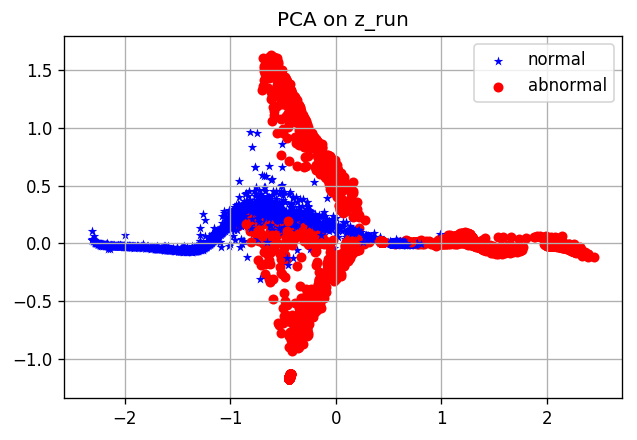

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.dpi'] = 120

# from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

#z_run = z_mean.to(torch.device('cpu'))
#z_run = z_run.detach().numpy()
PCA_model = TruncatedSVD(n_components=3).fit(z_runs)
z_run_reduced = PCA_model.transform(z_runs)
print (np.shape(z_run_reduced))
#ground_truth = targets_val.to(torch.device('cpu'))
ground_truth = val_label[:Batch*iters]
for k in range(Batch*iters):
    if ground_truth[k] ==1:
#z_mean, z_log_var, encoded, decoded = model(features, targets)
        plot1 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='b', marker='*', linewidths=0)
    else:
        plot2 = plt.scatter(z_run_reduced[k, 0], z_run_reduced[k, 1], c='r', marker='o', linewidths=0)        
plt.legend([plot1, plot2],('normal','abnormal'), loc='best')
plt.title('PCA on z_run')
plt.grid()
plt.show()

In [69]:
# save latenct vecotor dim = 20
np.savetxt('z_runs.txt',z_runs)
np.savetxt('ground_truth.txt',ground_truth)

(64, 1, 784)


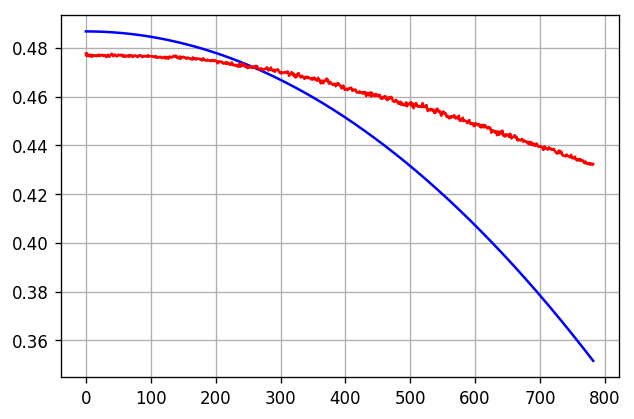

In [85]:
def data_to_real(inputdata):
    inputdata = inputdata * (inputdata.max()-inputdata.min()) + inputdata.min()
#    inputdata = 2.0 * inputdata - 1.0
    return inputdata

#features1 = features.view(-1,28*28)
input_data = features_val.to(torch.device('cpu'))
input_data = input_data.detach().numpy()
input_data = data_to_real(input_data)
print(np.shape(input_data))
input_data = np.reshape(input_data,(Batch,784))
input_data = input_data[:,:783]
de = model.decoder(z_mean) # replace decoded by z_mean

decoded_data = de.to(torch.device('cpu'))
#decoded_data = decoded_data.view(-1,28*28)
decoded_data = decoded_data.detach().numpy()
decoded_data = data_to_real(decoded_data)
decoded_data = np.reshape(decoded_data,(Batch,784))
decoded_data = decoded_data[:,:783]
idxx = np.random.randint(0,batch_size-1)
plt.plot(input_data[idxx],'b')
plt.plot(decoded_data[idxx],'r')
plt.grid()
plt.show()